In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import math
import torch
import torchvision
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import lbg_forecast.cosmology as cos
import lbg_forecast.priors_gp_csfrd as gp

In [2]:
def inverse(x):
    return x**2
def forward(x):
    return np.sqrt(x)

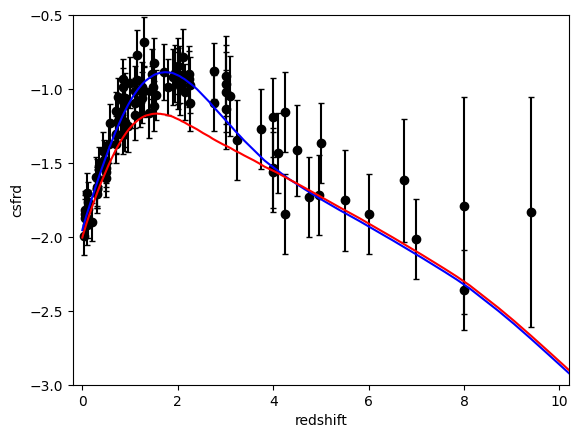

In [3]:
data = ascii.read("csfr_data/csfrs.dat")  

scale = np.array(data["Scale"])
redshift = cos.scale_to_z(scale)
total_obs_csfr = np.array(data["Total_Obs_CSFR"])
true_csfr = np.array(data["True_CSFR"])

plt.errorbar(redshift, np.log10(total_obs_csfr), zorder=1000, c="b")
plt.errorbar(redshift, np.log10(true_csfr), zorder=1000, c="r")
plt.xlim(-0.2, 10.2)
plt.ylim(-3, -0.5)

train_redshift, train_log_csfrd, train_log_shifted_csfrd, train_log_csfrd_errors, train_csfrd, train_csfrd_shifted, train_csfrd_errors = gp.get_training_data("./", True)

(np.float64(4.4408920985006264e-17), np.float64(0.9999999999999999))

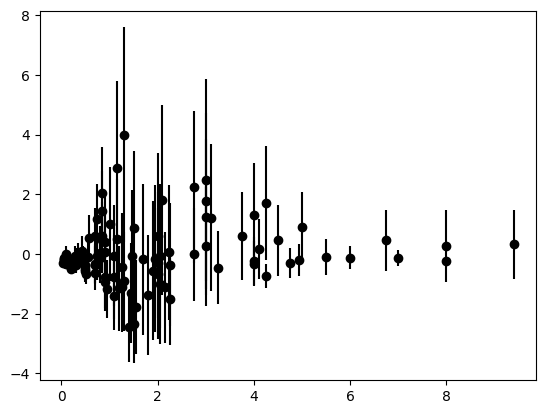

In [27]:
from uncertainties import unumpy as upy

cut=1000

train_log_csfrd_upy = upy.uarray(train_csfrd_shifted[:cut].numpy(), train_csfrd_errors[:cut].numpy())
csfrd_mean = np.mean(train_csfrd_shifted[:cut].numpy())
csfrd_std = np.std(train_csfrd_shifted[:cut].numpy())
train_log_csfrd_upy = (train_log_csfrd_upy - csfrd_mean)/csfrd_std

train_y = torch.from_numpy(upy.nominal_values(train_log_csfrd_upy))
train_yerrs = torch.from_numpy(upy.std_devs(train_log_csfrd_upy))
train_x = train_redshift[:cut]

plt.errorbar(train_x, train_y, train_yerrs, fmt='ko')
np.mean(train_y.numpy()), np.std(train_y.numpy())

In [32]:
training_iter=10000
lr = 0.1
test_x = torch.linspace(0, 10, 500)

class CSFRDModel(gpytorch.models.ExactGP):

    def __init__(self, train_x, train_y, lengthscale, scale, likelihood):
        super(CSFRDModel, self).__init__(train_x, train_y, likelihood)

        lengthscale_prior = gpytorch.priors.SmoothedBoxPrior(lengthscale[0], lengthscale[1])
        outscale_prior = gpytorch.priors.SmoothedBoxPrior(scale[0], scale[1])
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior))#gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=train_yerrs**2, learn_additional_noise=False)
model = CSFRDModel(train_x, train_y, [0.0, 7], [-999, 999], likelihood).to(torch.double)

model.train()
likelihood.train()

#print parameter values
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #i + 1, training_iter, loss.item(),
    print(loss.item())
        #model.likelihood.noise.item()
    #))
    optimizer.step()

#print parameter values
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')



model.eval()
f_preds = model(test_x.to(torch.double))


Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
1.159483737487883
1.155220608083382
1.1511172700030934
1.147155547429915
1.1433196318590806
1.1395960390131321
1.1359791243006294
1.132474102296371
1.129095412055601
1.1258623112443962
1.1227936332728556
1.119903198031293
1.1171974359777963
1.1146758862997213
1.1123336312143919
1.110163971602263
1.1081601436006427
1.1063158337715284
1.1046248989385545
1.1030808434986121
1.1016764415560474
1.1004036513299313
1.0992537906970659
1.0982178603072745
1.0972868946502286
1.0964522559334688
1.0957058300307352
1.095040120113375
1.0944482556309019
1.093923943173201
1.093461385578373
1.0930551907836523
1.0927002855781311
1.0923918434824085
1.092125231255012
1.0918959751437243
1.0916997457741318
1.0915323592133905
1.0913897910008996
1.0912681996007552
1.091163955672576
1.091073673698955
1.090994242803847
1.0909228540169513
1.090857021758865
1.0907945979119493

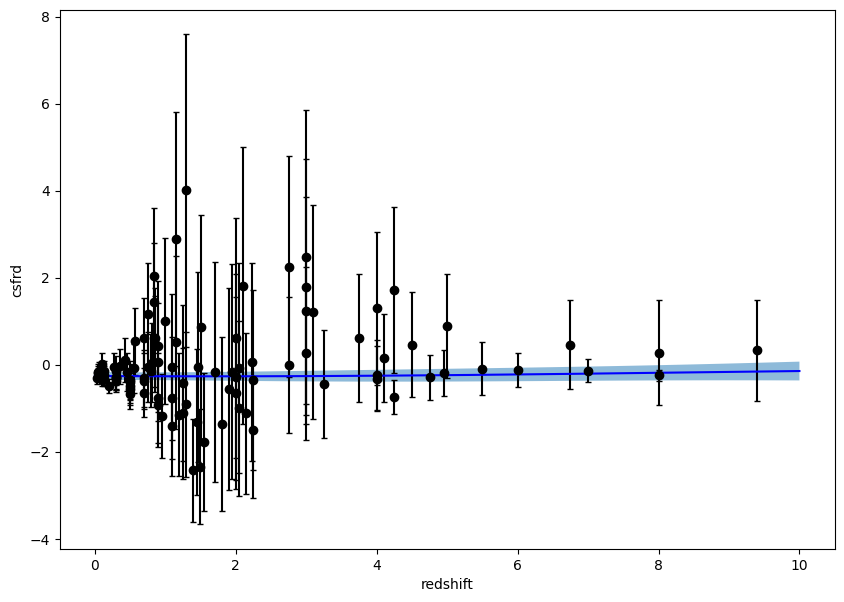

In [33]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_x.numpy(), train_y.numpy(), yerr=train_yerrs, fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), f_preds.mean, c='b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])

    ax.set_xlabel("redshift")
    ax.set_ylabel("csfrd")
    #ax.set_ylim(-2.7, -0.5)
    #ax.set_xlim(-0.0, 10)
    #ax.set_xscale('function', functions=(forward, inverse))

In [7]:
model, likelihood = gp.create_gp_model(train_x, train_y, train_yerrs, [0.0, 999], [-999, 999])
trained_model, trained_likelihood = gp.gp_training_loop(model, likelihood, train_x, train_y, training_iter=1000, lr=0.1)


Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
9.967687149288114
9.966838859332732
9.96603214028444
9.965267736396981
9.964546039988786
9.963867086525495
9.963230561939083
9.962635822126842
9.962081923786403
9.961567664910554
9.961091632337736
9.96065225261968
9.960247841011608
9.95987664170531
9.959536851298981
9.959226619125255
9.95894402602367
9.95868705897363
9.958453613861856
9.958241551354789
9.958048793157218
9.95787341161602
9.95771367451903
9.957568044369154
9.957435154514144
9.957313782142105
9.957202826674965
9.957101294250887
9.957008286393407
9.956922991040116
9.95684467481998
9.956772676046445
9.956706398216134
9.95664530394817
9.95658890935147
9.956536778819245
9.956488520246818
9.956443780662319
9.956402242253374
9.956363618768258
9.95632765226693
9.956294110195868
9.956262782760149
9.956233480566704
9.956206032513633
9.95618028390182
9.956156094746703
9.956133338269744
9.9561

In [8]:
test_redshift = torch.linspace(0.001, 10, 200)
f_preds = gp.gp_evaluate_model(trained_model, test_redshift)

ValueError: 'x' and 'y' must have the same size

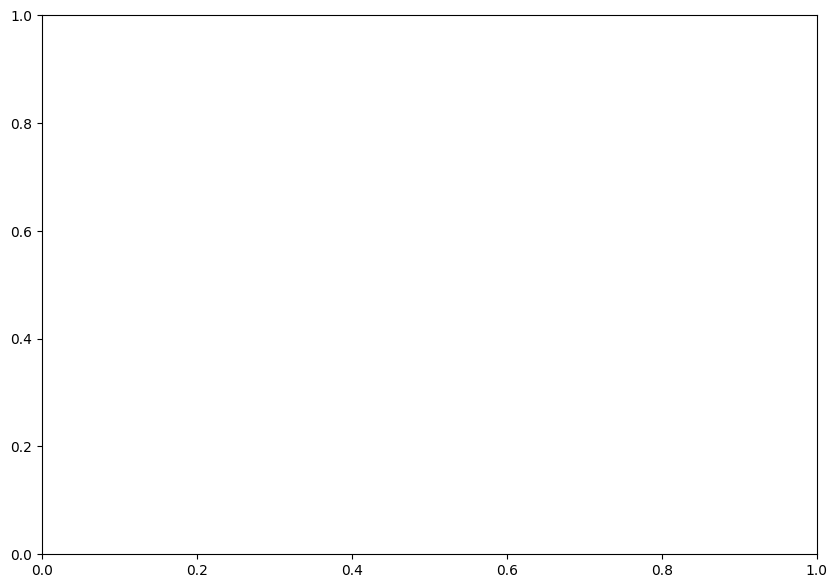

In [9]:
prospb = np.loadtxt("csfr_data/behroozi_19_sfrd.txt")
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    shift = gp.mean_obs_behroozi(test_redshift.numpy(), log=True, path='./')
    #ax.errorbar(redshift, np.log10(total_obs_csfr), zorder=1000)
    #ax.errorbar(redshift, np.log10(true_csfr), zorder=1000)

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_x.numpy(), train_log_csfrd.numpy(), yerr=train_log_csfrd_errors, fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_redshift.numpy(), f_preds.mean*csfrd_std+csfrd_mean+shift, c='b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_redshift.numpy(), lower*csfrd_std+csfrd_mean+shift, upper*csfrd_std+csfrd_mean+shift, alpha=0.5)
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])

    ax.set_xlabel("redshift")
    ax.set_ylabel("csfrd")
    #ax.set_ylim(-2.7, -0.5)
    #ax.set_xlim(-0.0, 10)
    #ax.set_xscale('function', functions=(forward, inverse))

In [9]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: covar_module.raw_outputscale               value = -3.393101088681073
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 2.3684402819206043


/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


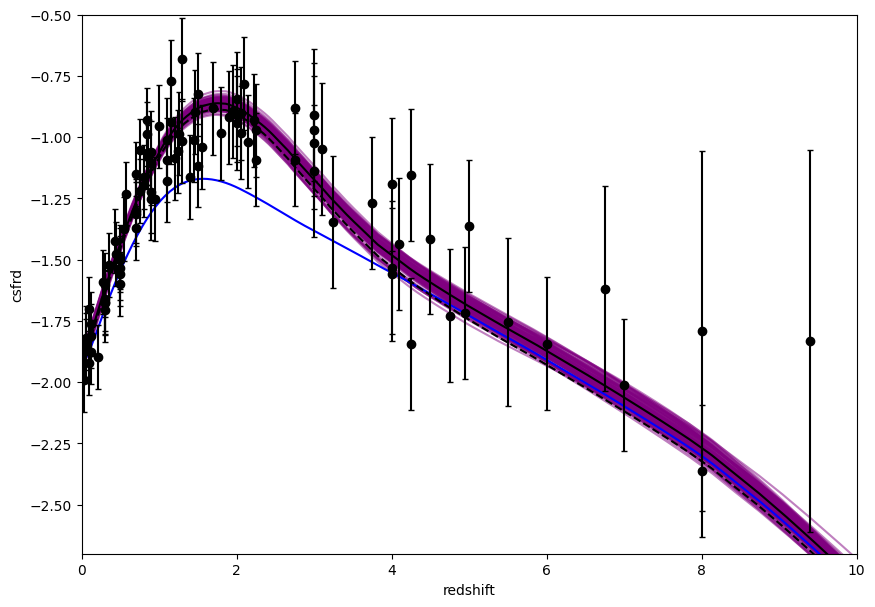

In [ ]:
prospb = np.loadtxt("csfr_data/behroozi_19_sfrd.txt")
with torch.no_grad():

    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    nsamples = 100
    for sample in range(nsamples):
        f_sample = f_preds.sample()*csfrd_std+csfrd_mean+shift
        #if((f_sample > 0.0).all()):
        ax.plot(test_redshift, f_sample, c='purple', alpha=0.5)
    ax.errorbar(redshift, np.log10(total_obs_csfr), zorder=1000, ls='--', c='k')
    ax.plot(test_redshift, f_preds.mean*csfrd_std+csfrd_mean+shift, zorder=1000, ls='-', c='k')
    ax.plot(prospb[:, 0], np.log10(prospb[:, 2]), c='b')
    ax.errorbar(train_x.numpy(), train_log_csfrd.numpy(), yerr=train_log_csfrd_errors, fmt='ko', capsize=2)
    
    ax.set_xlabel("redshift")
    ax.set_ylabel("csfrd")
    ax.set_ylim(-2.7, -0.5)
    ax.set_xlim(-0.0, 10)
    #ax.set_xscale('function', functions=(forward, inverse))

/var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/ipykernel_91253/635526763.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)


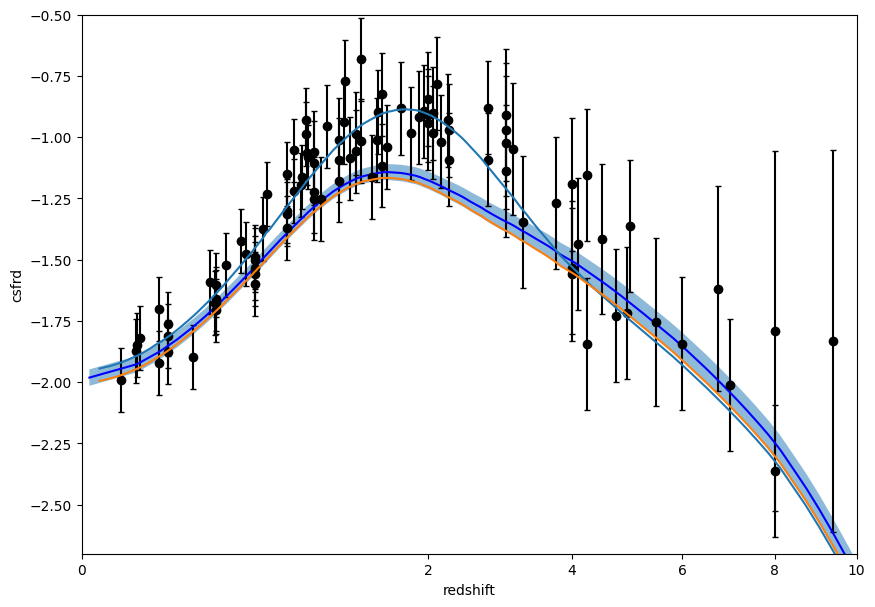

In [11]:
prospb = np.loadtxt("csfr_data/behroozi_19_sfrd.txt")
sys_shift = gp.systematic_shift(test_redshift, path='./')
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))


    ax.errorbar(redshift, np.log10(total_obs_csfr), zorder=1000)
    ax.errorbar(redshift, np.log10(true_csfr), zorder=1000)

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_x.numpy(), train_log_csfrd.numpy(), yerr=train_log_csfrd_errors, fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_redshift.numpy(), f_preds.mean*csfrd_std+csfrd_mean+shift-sys_shift, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_redshift.numpy(), lower*csfrd_std+csfrd_mean+shift-sys_shift, upper*csfrd_std+csfrd_mean+shift-sys_shift, alpha=0.5)

    ax.set_xlabel("redshift")
    ax.set_ylabel("csfrd")
    ax.set_ylim(-2.7, -0.5)
    ax.set_xlim(-0.0, 10)
    ax.set_xscale('function', functions=(forward, inverse))

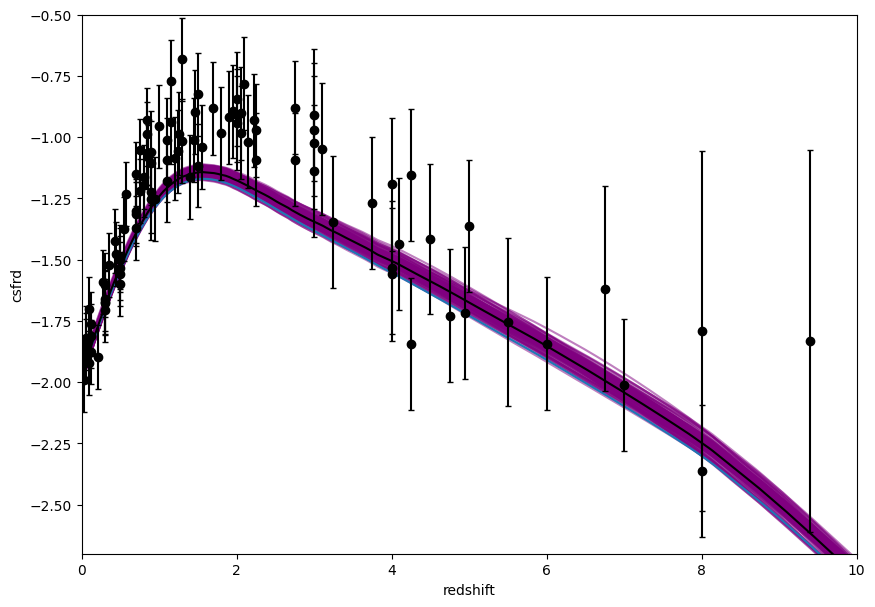

In [12]:
prospb = np.loadtxt("csfr_data/behroozi_19_sfrd.txt")
with torch.no_grad():

    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    nsamples = 100
    for sample in range(nsamples):
        f_sample = f_preds.sample()*csfrd_std+csfrd_mean+shift-sys_shift
        #if((f_sample > 0.0).all()):
        ax.plot(test_redshift, f_sample, c='purple', alpha=0.5)
    ax.errorbar(redshift, total_obs_csfr, zorder=1000, ls='--', c='k')
    ax.plot(test_redshift, f_preds.mean*csfrd_std+csfrd_mean+shift-sys_shift, zorder=1000, ls='-', c='k')
    ax.plot(prospb[:, 0], np.log10(prospb[:, 2]))
    ax.errorbar(train_x.numpy(), train_log_csfrd.numpy(), yerr=train_log_csfrd_errors, fmt='ko', capsize=2)
    
    ax.set_xlabel("redshift")
    ax.set_ylabel("csfrd")
    ax.set_ylim(-2.7, -0.5)
    ax.set_xlim(-0.0, 10)
    #ax.set_xscale('function', functions=(forward, inverse))


In [13]:
#torch.save(model.state_dict(), 'gp_models/csfrd.pth')